<a href="https://colab.research.google.com/github/Victor-Manach/numerai/blob/main/numerai_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numerapi

In [ ]:
!pip install -q --no-deps numerai-tools

In [ ]:
from typing import List, Dict, Any, Literal, Optional, Tuple, Callable
from pathlib import Path
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
import math
from torch.utils.data import TensorDataset, DataLoader, Dataset, Sampler
import time
import matplotlib.pyplot as plt
import seaborn as sns

from numerai_tools.scoring import numerai_corr, correlation_contribution
from tqdm.notebook import tqdm

import h5py

plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
path_to_drive = Path('/content/drive/My Drive')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cuda'


In [ ]:
DATA_VERSION = "v5.0"
MODEL_NAME = "MLP_RECONSTRUCT"
PATH_TO_DATA = path_to_drive / f"numerai/data/{DATA_VERSION}"
SKIP_TRAINING = False

In [ ]:
features_path = PATH_TO_DATA / "features.json"
TRAIN_PATH = PATH_TO_DATA / "train/train_v2.h5"
VALID_PATH = PATH_TO_DATA / "valid/valid_v2.h5"

MODEL_PATH = path_to_drive / f"numerai/models"

In [ ]:
feature_metadata = json.load(open(features_path))
all_target_cols = feature_metadata["targets"]
feature_sets = feature_metadata["feature_sets"]

sm_feature_set = feature_sets["small"]
med_feature_set = feature_sets["medium"]
all_feature_set = feature_sets["all"]

ERA_COL = "era"
MAIN_TARGET = "target"
AUXILIARY_TARGETS = [
  "target_victor_20",
  "target_xerxes_20",
  "target_teager2b_20",
  "target_caroline_20",
  "target_sam_20",
  "target_echo_20",
  "target_alpha_20",
  "target_jeremy_20"
]

feature_set = med_feature_set

In [ ]:
def load_features_id(features_to_use, h5_file):
    feature_to_id_file = h5_file.parent / "feature_to_id.json"
    with open(feature_to_id_file, 'r') as f:
        feature_to_id = json.load(f)
    features_id = [feature_to_id[f] for f in features_to_use]

    return features_id

def load_targets_id(targets_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    targets_id = [target_to_id[t] for t in targets_to_use]

    return targets_id

def load_target_id(target_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    target_id = target_to_id[target_to_use]

    return target_id

def load_eras_data(keep_eras, h5_file):
    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        idx_list = []
        if keep_eras is not None:
            for era in keep_eras:
                era_key = str(era).zfill(4)
                if era_key in era_ix:
                    idx_list.append(era_ix[era_key][:])
                    era_vector.append([era]*len(era_ix[era_key]))
            if idx_list:
                indices = np.concatenate(idx_list)
            else:
                indices = np.array([], dtype=np.int64)
            features = f['features'][indices, :]
        else:
            features = f['features'][:]

    era_vector = np.concatenate(era_vector)
    return features, era_vector

def load_first_n_eras_data(n, h5_file):
    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        era_keys = sorted(list(era_ix.keys()))
        first_n_keys = era_keys[:n]
        idx_list = []
        for era_key in first_n_keys:
            idx_list.append(era_ix[era_key][:])
            era_vector.append([int(era_key)]*len(era_ix[era_key]))
        if idx_list:
            indices = np.concatenate(idx_list)
        else:
            indices = np.array([], dtype=np.int64)
        features = f['features'][indices, :]

    era_vector = np.concatenate(era_vector)
    return features, era_vector, [int(e) for e in first_n_keys]

def load_eras_data_and_filter_columns(keep_eras, h5_file, features_to_use):
    features, era_vector = load_eras_data(keep_eras, h5_file)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], era_vector

def load_first_n_eras_data_and_filter_columns(n, h5_file, features_to_use):
    features, era_vector, first_n_eras = load_first_n_eras_data(n, h5_file)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], era_vector, first_n_eras

In [ ]:
train_eras = [i for i in range(500, 900)]
x_train_np, train_era_vector_np = load_eras_data_and_filter_columns(train_eras, TRAIN_PATH, feature_set)

In [ ]:
x_train = torch.tensor(x_train_np, dtype=torch.float32)
train_era_vector_pt = torch.tensor(train_era_vector_np, dtype=torch.int32)

x_train.shape, train_era_vector_pt.shape

(torch.Size([2317942, 705]), torch.Size([2317942]))

In [ ]:
train_era_vector_pt.min(), train_era_vector_pt.max()

(tensor(500, dtype=torch.int32), tensor(899, dtype=torch.int32))

In [ ]:
x_train = (x_train - 2.0) / 2.0

In [ ]:
x_train = x_train.float()

In [ ]:
n = 80
x_valid_np, valid_era_vector_np, valid_eras = load_first_n_eras_data_and_filter_columns(n, VALID_PATH, feature_set)

In [ ]:
x_valid = torch.tensor(x_valid_np, dtype=torch.float32)
valid_era_vector_pt = torch.tensor(valid_era_vector_np, dtype=torch.int32)

x_valid.shape, valid_era_vector_pt.shape

(torch.Size([527296, 705]), torch.Size([527296]))

In [ ]:
valid_era_vector_pt.min(), valid_era_vector_pt.max()

(tensor(975, dtype=torch.int32), tensor(1054, dtype=torch.int32))

In [ ]:
x_valid = (x_valid - 2.0) / 2.0

In [ ]:
x_valid = x_valid.float()

In [ ]:
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.ln = nn.LayerNorm(input_dim, **factory_kwargs)
        self.c_fc = nn.Linear(input_dim, input_dim, bias=True, **factory_kwargs)
        self.c_proj = nn.Linear(input_dim, output_dim, bias=True, **factory_kwargs)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.ln(x)
        x = x + self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        hidden_dims = [config.n_embd//2**i for i in range(config.n_layers+1)]
        self.embedding = nn.Linear(config.input_dim, config.n_embd, bias=True, **factory_kwargs)
        self.encoder_layers = nn.ModuleList([FFN(hidden_dims[i], hidden_dims[i+1], **factory_kwargs) for i in range(len(hidden_dims)-1)])
        self.decoder_layers = nn.ModuleList([FFN(hidden_dims[i], hidden_dims[i-1], **factory_kwargs) for i in range(len(hidden_dims)-1, 0, -1)])
        self.decoder = nn.Linear(config.n_embd, config.input_dim, bias=True, **factory_kwargs)

        self.config = config

    def encode(self, x):
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decode(self, z):
        for layer in self.decoder_layers:
            z = layer(z)
        return self.decoder(z)

    def forward(self, x):
        x, mask = self.apply_mask(x)
        z = self.encode(x)
        return self.decode(z), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

    def configure_optimizer(self, weight_decay, learning_rate, betas, device_type):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] # all weight tensors in matmuls + embeddings decay
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] # all biases and layernorms

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        use_fused = (device_type == 'cuda')
        extra_args = dict(fused=True) if use_fused else dict()

        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

In [ ]:
class MlpBlock(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.ln = nn.LayerNorm(config.n_embd, **factory_kwargs)
        self.c_fc = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        self.ln_pre_activation = x.clone()
        x = self.ln(x)
        self.ln_activation = x.clone()
        x = self.c_fc(x)
        self.gelu_pre_activation = x.clone()
        x = self.gelu(x)
        self.gelu_activation = x.clone()
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class MlpReconstruct(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.embedding = nn.Linear(config.input_dim, config.n_embd, bias=True, **factory_kwargs)
        self.layers = nn.ModuleList([MlpBlock(config, **factory_kwargs) for _ in range(config.n_layers)])

        self.main_proj = nn.Linear(config.n_embd, config.input_dim, bias=True, **factory_kwargs)
        self.aux_proj = nn.Identity()

        self.config = config
        self.stats = {}

    def forward(self, x):
        x, mask = self.apply_mask(x)
        x = self.embedding(x)
        self.post_embedding = x.clone()
        for i,layer in enumerate(self.layers):
            x_ffn = layer(x)
            self.stats[f"block{i}_ffn"] = (x_ffn.mean(), x_ffn.std(), x_ffn.min(), x_ffn.max())
            self.stats[f"block{i}_res"] = (x.mean(), x.std(), x.min(), x.max())
            x = x + x_ffn

        self.post_core = x.clone()

        return self.main_proj(x), self.aux_proj(x), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

    def configure_optimizer(self, weight_decay, learning_rate, betas, device_type):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] # all weight tensors in matmuls + embeddings decay
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] # all biases and layernorms

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        use_fused = (device_type == 'cuda')
        extra_args = dict(fused=True) if use_fused else dict()

        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

In [ ]:
@dataclass
class AutoEncoderConfig:
    input_dim: int
    latent_dim: int
    n_layers: int
    n_embd: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

In [ ]:
@dataclass
class MlpReconstructConfig:
    input_dim: int
    main_output_dim: int
    aux_output_dim: int
    n_layers: int
    n_embd: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

In [ ]:
# config = AutoEncoderConfig(
#     input_dim=len(feature_set),
#     latent_dim=64,
#     n_layers=2,
#     n_embd=256,
#     dropout=0.0,
#     bias=True,
#     mask_ratio=0.3,
#     noise_std=0.1
# )

config = MlpReconstructConfig(
    input_dim=len(feature_set),
    main_output_dim=1,
    aux_output_dim=len(AUXILIARY_TARGETS),
    n_layers=4,
    n_embd=256,
    dropout=0.0,
    bias=True,
    mask_ratio=0.4,
    noise_std=0.2
)

In [ ]:
batch_size = 512
total_batch_size = 721920
assert total_batch_size % (batch_size*config.input_dim) == 0
grad_accum_steps = total_batch_size // (batch_size*config.input_dim)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

Total desired batch size: 721920
=> calculated gradient accumulation steps: 2


In [ ]:
model = MlpReconstruct(config).to(device)

with torch.no_grad():
    model.main_proj.weight *= 3.0

model = torch.compile(model)

In [ ]:
n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params:,}")

Number of parameters: 890,305


In [ ]:
max_steps = 10000
val_loss_n_steps = 200
learning_rate = 6e-4
decay_lr = False
warmup_iters = 400
lr_decay_iters = max_steps # should be ~= max_iters
min_lr = 6e-5 # should be ~= learning_rate/10
weight_decay = 1e-1
betas = (0.9, 0.999)
epsilon = 1e-8
lambda_coef = 10.0
desired_variance = 0.05
gamma = 3.0

dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
torch.set_float32_matmul_precision("high")

np.random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

In [ ]:
train_dataset = TensorDataset(x_train, train_era_vector_pt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_dataset = TensorDataset(x_valid, valid_era_vector_pt)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataset), len(valid_dataset)

(2317942, 527296)

In [ ]:
len(train_loader), len(valid_loader)

(4528, 1030)

In [ ]:
optimizer = model.configure_optimizer(weight_decay, learning_rate, betas, device)

num decayed parameter tensors: 10, with 885,248 parameters
num non-decayed parameter tensors: 18, with 5,057 parameters
using fused AdamW: True


In [ ]:
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * (it + 1) / (warmup_iters + 1)
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

get_lr_with_default_values = lambda it: get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)

In [ ]:
def masked_mse_loss(pred, target, mask):
    return ((pred - target)**2 * mask.float()).sum() / mask.float().sum().clamp_min(1e-8)

In [ ]:
loss_fn = masked_mse_loss

In [ ]:
# debug cell
# train_losses, valid_losses = [], []

# train_loader_iter = iter(train_loader)
# for step in range(max_steps):
#     model.train(True)
#     lr = get_lr_with_default_values(step) if decay_lr else learning_rate
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

#     optimizer.zero_grad()
#     xb, _ = next(train_loader_iter)
#     xb = xb.to(device)

#     with torch.autocast(device_type=device, dtype=dtype):
#         xb_hat, _, mask = model(xb)
#         loss = loss_fn(xb_hat, xb, mask)

#     loss.backward()
#     norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#     optimizer.step()

#     break

In [ ]:
# assert False, "stop debug here"

In [ ]:
train_losses, valid_losses = [], []

train_loader_iter = iter(train_loader)
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    if step % val_loss_n_steps == 0 or last_step:
        model.eval()
        valid_loader_iter = iter(valid_loader)
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = len(valid_loader)
            for _ in range(val_loss_steps):
                xb, _ = next(valid_loader_iter)
                xb = xb.to(device)
                with torch.autocast(device_type=device, dtype=dtype):
                    xb_hat, _, mask = model(xb)
                    loss = loss_fn(xb_hat, xb, mask)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        print(f"step {step+1:3d}/{max_steps:3d} | val_loss={val_loss_accum.item():.4f}")
        valid_losses.append(val_loss_accum.item())

    model.train(True)
    lr = get_lr_with_default_values(step) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        try:
            xb, _ = next(train_loader_iter)
        except StopIteration:
            train_loader_iter = iter(train_loader)
            xb, _ = next(train_loader_iter)

        xb = xb.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            xb_hat, _, mask = model(xb)
            loss = loss_fn(xb_hat, xb, mask)

        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    if step % 50 == 0 or last_step:
        print(f"step {step+1:3d}/{max_steps:3d} | loss={loss_accum.item():.6f} | lr={lr:.6e} | norm={norm:.4f} | dt={dt*1000:.2f}ms")

    train_losses.append(loss_accum.item())

step   1/10000 | val_loss=1.3127
step   1/10000 | loss=1.315024 | lr=1.496259e-06 | norm=0.8468 | dt=7972.38ms
step  51/10000 | loss=0.922302 | lr=7.630923e-05 | norm=0.3333 | dt=48.18ms
step 101/10000 | loss=0.627861 | lr=1.511222e-04 | norm=0.1773 | dt=42.66ms
step 151/10000 | loss=0.472197 | lr=2.259352e-04 | norm=0.1185 | dt=43.51ms
step 201/10000 | val_loss=0.3846
step 201/10000 | loss=0.381074 | lr=3.007481e-04 | norm=0.0919 | dt=8115.40ms
step 251/10000 | loss=0.329336 | lr=3.755611e-04 | norm=0.1038 | dt=41.92ms
step 301/10000 | loss=0.304285 | lr=4.503741e-04 | norm=0.1396 | dt=41.84ms
step 351/10000 | loss=0.284179 | lr=5.251870e-04 | norm=0.1525 | dt=42.94ms
step 401/10000 | val_loss=0.2752
step 401/10000 | loss=0.270028 | lr=6.000000e-04 | norm=0.1558 | dt=7796.67ms
step 451/10000 | loss=0.260854 | lr=5.999639e-04 | norm=0.1502 | dt=42.65ms
step 501/10000 | loss=0.251706 | lr=5.998554e-04 | norm=0.1390 | dt=42.04ms
step 551/10000 | loss=0.248780 | lr=5.996748e-04 | norm=0.1

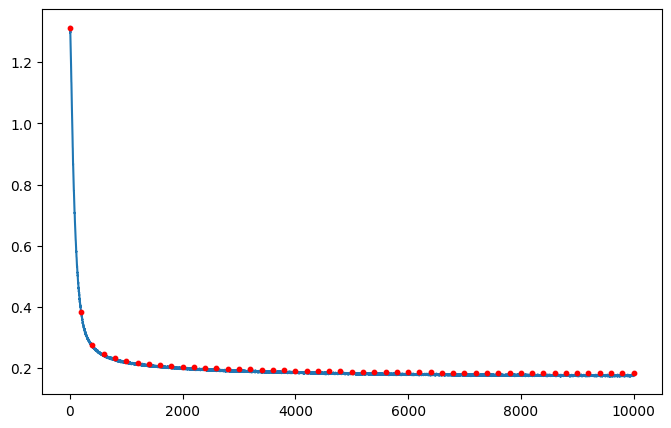

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.scatter(np.arange(len(valid_losses))*val_loss_n_steps, valid_losses, color='red', zorder=3, s=10)
plt.show()

# Save the model

In [ ]:
checkpoint = {
    'model': model._orig_mod.state_dict(),
    'config': config
}
# torch.save(checkpoint, MODEL_PATH/f"{MODEL_NAME}.pt")

In [ ]:
assert False, "stop here"

AssertionError: stop here

----
# Validation

In [ ]:
model.eval()

In [ ]:
# inference_train_loader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=8,
#     pin_memory=True
# )

inference_train_loader = train_loader

In [ ]:
train_predictions = []
train_targets = []
used_train_eras = []

with torch.no_grad():
    for batch in tqdm(inference_train_loader):
        features, _, targets, _, eras, _ = batch
        features = features.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            t_predictions, _ = model(features)

        predictions = t_predictions.squeeze(-1).float().cpu().numpy()
        targets = targets.numpy()

        train_predictions.append(predictions)
        train_targets.append(targets)
        used_train_eras.append(eras)

train_predictions = np.concatenate(train_predictions, axis=0)
train_targets = np.concatenate(train_targets, axis=0)
used_train_eras = np.concatenate(used_train_eras, axis=0)

In [ ]:
df_train_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_train_eras],
        'target': train_targets,
        MODEL_NAME: train_predictions
    }
)

In [ ]:
df_train_preds[MODEL_NAME].describe()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.histplot(data=df_train_preds, x=MODEL_NAME, bins=200)

# Customize the plot to match your original settings
plt.title("Train predictions")
plt.xlabel('Observation')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
per_era_corr = df_train_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

----

In [ ]:
# inference_valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=8,
#     pin_memory=True
# )

inference_valid_loader = valid_loader

In [ ]:
valid_predictions = []
valid_targets = []
used_valid_eras = []

with torch.no_grad():
    for batch in tqdm(inference_valid_loader):
        features, _, targets, _, eras, _ = batch
        features = features.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            t_predictions, _ = model(features)

        predictions = t_predictions.squeeze(-1).float().cpu().numpy()
        targets = targets.numpy()

        valid_predictions.append(predictions)
        valid_targets.append(targets)
        used_valid_eras.append(eras)

valid_predictions = np.concatenate(valid_predictions, axis=0)
valid_targets = np.concatenate(valid_targets, axis=0)
used_valid_eras = np.concatenate(used_valid_eras, axis=0)

In [ ]:
df_validation_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_valid_eras],
        'target': valid_targets,
        MODEL_NAME: valid_predictions
    }
).dropna()

In [ ]:
df_validation_preds[MODEL_NAME].describe()

In [ ]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = df_validation_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean.values[0]],
    "std": [corr_std.values[0]],
    "sharpe": [corr_sharpe.values[0]],
    "max_drawdown": [corr_max_drawdown.values[0]]
}, index=["CORR"]).T